## Using RNNs to classify sentiment on IMDB data

In this assignment,you will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.


Walk through the followinng steps to prepare the data and the building of an RNN model. 

In [1]:
from keras.datasets import imdb
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from keras.layers.recurrent import SimpleRNN
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from keras.layers.embeddings import Embedding
from tensorflow.keras import initializers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30. 

In [2]:
# number of words to consider as features
max_features = 20000 
# Maximum sequence length. Any longer sequence will be truncated.
max_len = 30

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)

3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [3]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


4- Pad (or truncate) the sequences so that they are of the maximum length

In [4]:
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

5- After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [5]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 30)
x_test shape: (25000, 30)


## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla) RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






6- Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [6]:


tf.random.set_seed(123)

model = Sequential()

# Add an Embedding layer expecting input vocab of size 20000, and
# output embedding dimension of size 50.
model.add(Embedding(input_dim=20000, output_dim=50))
model.add(SimpleRNN(5, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))


2022-02-20 13:05:52.298678: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7- How many parameters have the embedding layer?

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 5)                 280       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


The embedding layer has 1000000 Parameters

8- Train the network with the RMSprop with learning rate of .0001 and epochs=10.

In [8]:
# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

Epoch 1/10
157/157 [==============================] - 10s 43ms/step - loss: 0.2490 - acc: 0.5767 - val_loss: 0.2463 - val_acc: 0.6678
Epoch 2/10
157/157 [==============================] - 6s 35ms/step - loss: 0.2391 - acc: 0.6737 - val_loss: 0.2322 - val_acc: 0.6770
Epoch 3/10
157/157 [==============================] - 6s 38ms/step - loss: 0.2246 - acc: 0.6896 - val_loss: 0.2229 - val_acc: 0.6758
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2144 - acc: 0.7090 - val_loss: 0.2188 - val_acc: 0.6764
Epoch 5/10
157/157 [==============================] - 6s 36ms/step - loss: 0.2061 - acc: 0.7298 - val_loss: 0.2161 - val_acc: 0.6806
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1986 - acc: 0.7450 - val_loss: 0.2134 - val_acc: 0.6804
Epoch 7/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1914 - acc: 0.7612 - val_loss: 0.2113 - val_acc: 0.6832
Epoch 8/10
157/157 [==============================] - 6s 36ms/step -

9- PLot the loss and accuracy metrics during the training and interpret the result.

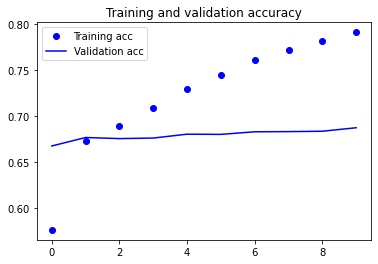

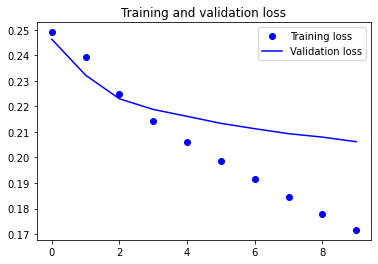

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the above graphs we can clearly see that the model is overfitting. The Accuracy of the train set keeps increasing while this is not reflected in the validation set. As the number of epochs increases the difference in accuracy of train and validation also increases. Similarly, the loss keeps decreasing for train set but it plateaus for validation set after few epochs. 

10- Check the accuracy and the loss of your models on the test dataset.

In [10]:
model.metrics_names

['loss', 'acc']

In [11]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 68.66%
loss: 0.21


## Tuning The Vanilla RNN Network


11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model.  Did it improve the performance?

In [12]:
#Changing max length to 80 and checking accuracy 
max_len = 80

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()

# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(5, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

Epoch 1/10
157/157 [==============================] - 16s 80ms/step - loss: 0.2482 - acc: 0.5613 - val_loss: 0.2413 - val_acc: 0.6568
Epoch 2/10
157/157 [==============================] - 7s 42ms/step - loss: 0.2335 - acc: 0.6712 - val_loss: 0.2298 - val_acc: 0.6726
Epoch 3/10
157/157 [==============================] - 5s 34ms/step - loss: 0.2221 - acc: 0.7082 - val_loss: 0.2212 - val_acc: 0.7054
Epoch 4/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2125 - acc: 0.7390 - val_loss: 0.2180 - val_acc: 0.6982
Epoch 5/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2036 - acc: 0.7605 - val_loss: 0.2177 - val_acc: 0.6892
Epoch 6/10
157/157 [==============================] - 5s 33ms/step - loss: 0.1954 - acc: 0.7744 - val_loss: 0.2074 - val_acc: 0.7186
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.1873 - acc: 0.7875 - val_loss: 0.2050 - val_acc: 0.7162
Epoch 8/10
157/157 [==============================] - 5s 34ms/step -

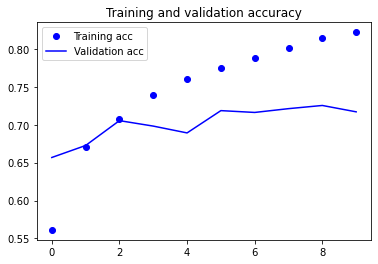

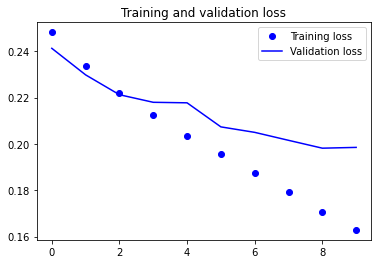

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 69.81%
loss: 0.21


We observe that the model is slightly better than the last model but there still appears to be overfitting.

12- Try different values of the  maximum length of a sequence ("max_features").  Can you improve the performance?

In [15]:
#Changing max features to 10000 and checking accuracy 
max_features = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()

# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(5, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)


Epoch 1/10
157/157 [==============================] - 7s 32ms/step - loss: 0.2488 - acc: 0.5673 - val_loss: 0.2451 - val_acc: 0.6710
Epoch 2/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2392 - acc: 0.6973 - val_loss: 0.2346 - val_acc: 0.7030
Epoch 3/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2302 - acc: 0.7308 - val_loss: 0.2325 - val_acc: 0.6880
Epoch 4/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2245 - acc: 0.7484 - val_loss: 0.2276 - val_acc: 0.7100
Epoch 5/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2195 - acc: 0.7636 - val_loss: 0.2255 - val_acc: 0.7132
Epoch 6/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2151 - acc: 0.7714 - val_loss: 0.2246 - val_acc: 0.7082
Epoch 7/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2105 - acc: 0.7788 - val_loss: 0.2212 - val_acc: 0.7260
Epoch 8/10
157/157 [==============================] - 5s 31ms/step - 

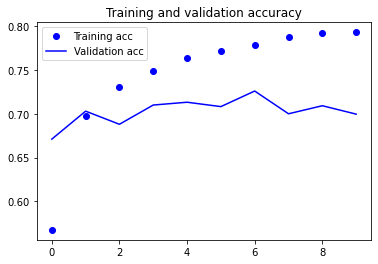

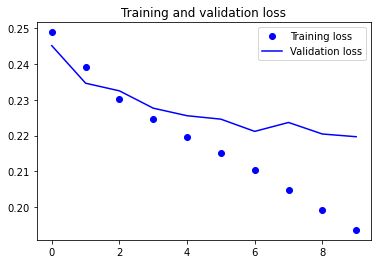

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 68.22%
loss: 0.22


There is no considerable change in the accuracy of model and, there is still overfitting.

In [18]:
#Changing max features to 30000 and checking accuracy 
max_features = 30000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()


# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(5, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

Epoch 1/10
157/157 [==============================] - 7s 36ms/step - loss: 0.2473 - acc: 0.5804 - val_loss: 0.2396 - val_acc: 0.6844
Epoch 2/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2330 - acc: 0.6999 - val_loss: 0.2290 - val_acc: 0.7080
Epoch 3/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2243 - acc: 0.7342 - val_loss: 0.2306 - val_acc: 0.6714
Epoch 4/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2181 - acc: 0.7579 - val_loss: 0.2220 - val_acc: 0.7200
Epoch 5/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2122 - acc: 0.7749 - val_loss: 0.2220 - val_acc: 0.7044
Epoch 6/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2061 - acc: 0.7864 - val_loss: 0.2165 - val_acc: 0.7226
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2002 - acc: 0.7987 - val_loss: 0.2160 - val_acc: 0.7094
Epoch 8/10
157/157 [==============================] - 5s 34ms/step - 

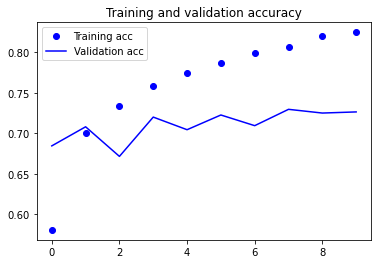

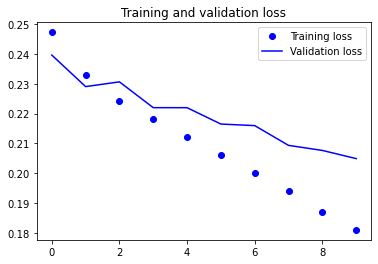

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 70.59%
loss: 0.21


Increasing the max features to 30000 increases the accuracy slightly but there is still overfitting. 

13- Try smaller and larger sizes of the RNN hidden dimension.  How does it affect the model performance?  How does it affect the run time?

In [21]:
#Changing RNN hidden dimension to 3 
max_features = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()


# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(3, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

/Users/harukageorge/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 7s 35ms/step - loss: 0.2500 - acc: 0.5041 - val_loss: 0.2500 - val_acc: 0.5100
Epoch 2/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2496 - acc: 0.5429 - val_loss: 0.2498 - val_acc: 0.5172
Epoch 3/10
157/157 [==============================] - 5s 31ms/step - loss: 0.2471 - acc: 0.5717 - val_loss: 0.2500 - val_acc: 0.5144
Epoch 4/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2396 - acc: 0.5940 - val_loss: 0.2527 - val_acc: 0.5154
Epoch 5/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2300 - acc: 0.6291 - val_loss: 0.2569 - val_acc: 0.5162
Epoch 6/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2201 - acc: 0.6622 - val_loss: 0.2601 - val_acc: 0.5200
Epoch 7/10
157/157 [==============================] - 5s 31ms/step - loss: 0.2105 - acc: 0.6923 - val_loss: 0.2632 - val_acc: 0.5176
Epoch 8/10
157/157 [==============================] - 5s 32ms/step - 

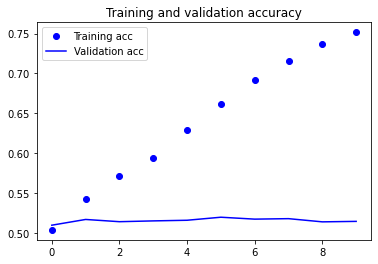

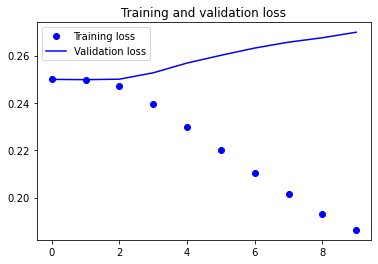

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 50.54%
loss: 0.27


The performance of the model reduces greatly with a lot of overfitting.

In [24]:
#Changing RNN hidden dimension to 7
max_features = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()


# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(7, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

Epoch 1/10
157/157 [==============================] - 7s 33ms/step - loss: 0.2482 - acc: 0.5573 - val_loss: 0.2404 - val_acc: 0.6558
Epoch 2/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2338 - acc: 0.6656 - val_loss: 0.2297 - val_acc: 0.6786
Epoch 3/10
157/157 [==============================] - 5s 31ms/step - loss: 0.2236 - acc: 0.7051 - val_loss: 0.2283 - val_acc: 0.6638
Epoch 4/10
157/157 [==============================] - 5s 30ms/step - loss: 0.2156 - acc: 0.7269 - val_loss: 0.2197 - val_acc: 0.6938
Epoch 5/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2069 - acc: 0.7505 - val_loss: 0.2199 - val_acc: 0.6836
Epoch 6/10
157/157 [==============================] - 5s 32ms/step - loss: 0.1996 - acc: 0.7663 - val_loss: 0.2112 - val_acc: 0.7102
Epoch 7/10
157/157 [==============================] - 5s 32ms/step - loss: 0.1919 - acc: 0.7814 - val_loss: 0.2075 - val_acc: 0.7154
Epoch 8/10
157/157 [==============================] - 5s 33ms/step - 

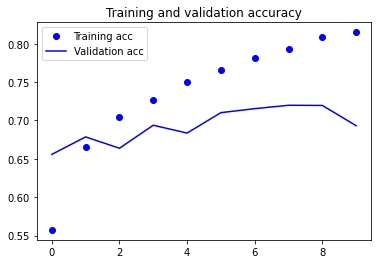

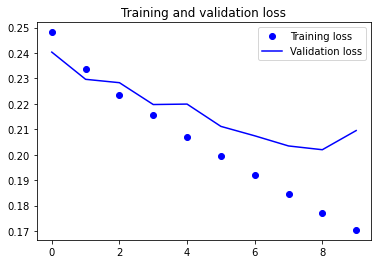

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 67.84%
loss: 0.21


Increasing the hidden units to 7 does not seem to have any significant changes.

In [27]:
max_features = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)
# Padding or truncating the sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()


# output embedding dimension of size 50.
model.add(Embedding(input_dim=max_features, output_dim=50))
model.add(SimpleRNN(10, kernel_initializer=initializers.RandomNormal(stddev=0.001)))
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, 
                   verbose=1)

Epoch 1/10
157/157 [==============================] - 7s 34ms/step - loss: 0.2500 - acc: 0.5095 - val_loss: 0.2498 - val_acc: 0.5284
Epoch 2/10
157/157 [==============================] - 5s 31ms/step - loss: 0.2486 - acc: 0.5503 - val_loss: 0.2476 - val_acc: 0.5302
Epoch 3/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2398 - acc: 0.5905 - val_loss: 0.2444 - val_acc: 0.5582
Epoch 4/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2299 - acc: 0.6337 - val_loss: 0.2429 - val_acc: 0.5758
Epoch 5/10
157/157 [==============================] - 5s 31ms/step - loss: 0.2222 - acc: 0.6607 - val_loss: 0.2427 - val_acc: 0.5874
Epoch 6/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2142 - acc: 0.6852 - val_loss: 0.2407 - val_acc: 0.5932
Epoch 7/10
157/157 [==============================] - 5s 32ms/step - loss: 0.2063 - acc: 0.7043 - val_loss: 0.2418 - val_acc: 0.5922
Epoch 8/10
157/157 [==============================] - 5s 32ms/step - 

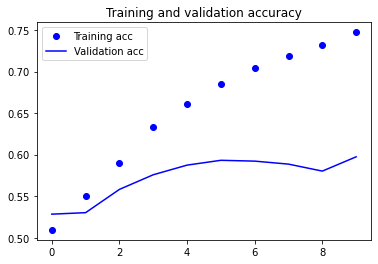

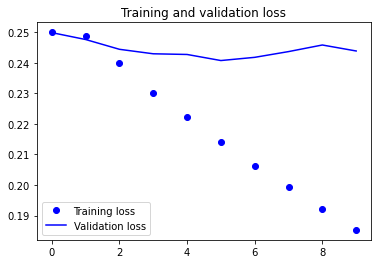

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 59.20%
loss: 0.25


When we further increase the hidden units to 10 then accuracy drops and there is high overfitting.

## Train LSTM and GRU networks


14- Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

In [30]:
## Building LSTM network 

# Number of words to consider as features
max_features = 20000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 80

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=12)

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 50))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 15s 80ms/step - loss: 0.1646 - acc: 0.7612 - val_loss: 0.1284 - val_acc: 0.8270
Epoch 2/10
157/157 [==============================] - 12s 75ms/step - loss: 0.0919 - acc: 0.8765 - val_loss: 0.1133 - val_acc: 0.8422
Epoch 3/10
157/157 [==============================] - 11s 69ms/step - loss: 0.0706 - acc: 0.9081 - val_loss: 0.1253 - val_acc: 0.8322
Epoch 4/10
157/157 [==============================] - 11s 72ms/step - loss: 0.0589 - acc: 0.9237 - val_loss: 0.1198 - val_acc: 0.8420
Epoch 5/10
157/157 [==============================] - 14s 89ms/step - loss: 0.0500 - acc: 0.9390 - val_loss: 0.1265 - val_acc: 0.8334
Epoch 6/10
157/157 [==============================] - 13s 86ms/step - loss: 0.0437 - acc: 0.9461 - val_loss: 0.1605 - val_acc: 0.8030
Epoch 7/10
157/157 [==============================] - 17s 106ms/step - loss: 0.0365 - acc: 0.9559 - val_loss: 0.1367 - val_acc: 0.8196
Epoch 8/10
157/157 [==============================] - 23s 147

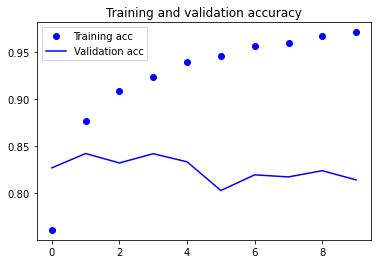

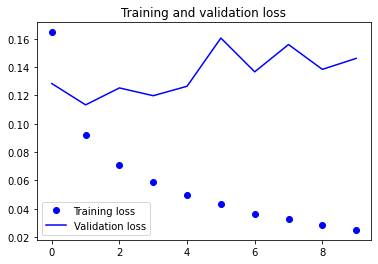

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 80.45%
loss: 0.15


Using the LSTM network greatly increases the accuracy of model but there is still a lot of overfitting.

In [33]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(GRU(32))
model.add(Dense(1))

model.compile(optimizer=RMSprop(lr=0.0001), loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 22s 107ms/step - loss: 0.3558 - acc: 0.5012 - val_loss: 0.2511 - val_acc: 0.5258
Epoch 2/10
157/157 [==============================] - 13s 83ms/step - loss: 0.2346 - acc: 0.6020 - val_loss: 0.2280 - val_acc: 0.6234
Epoch 3/10
157/157 [==============================] - 15s 98ms/step - loss: 0.2142 - acc: 0.6705 - val_loss: 0.2101 - val_acc: 0.6652
Epoch 4/10
157/157 [==============================] - 17s 105ms/step - loss: 0.1912 - acc: 0.7161 - val_loss: 0.1915 - val_acc: 0.7048
Epoch 5/10
157/157 [==============================] - 17s 110ms/step - loss: 0.1686 - acc: 0.7631 - val_loss: 0.1755 - val_acc: 0.7406
Epoch 6/10
157/157 [==============================] - 16s 104ms/step - loss: 0.1482 - acc: 0.8043 - val_loss: 0.1616 - val_acc: 0.7766
Epoch 7/10
157/157 [==============================] - 18s 112ms/step - loss: 0.1331 - acc: 0.8322 - val_loss: 0.1528 - val_acc: 0.7936
Epoch 8/10
157/157 [==============================] - 16s

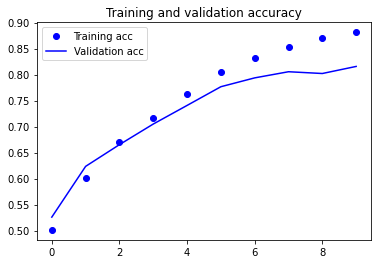

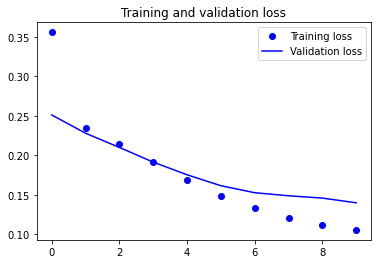

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 81.58%
loss: 0.14


Using the GRU network increases the accuracy, as well as, there is less overfitting. 

In [36]:
## Building LSTM model with Bidirectional layer

model = Sequential()
model.add(Embedding(max_features, 50))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 31s 149ms/step - loss: 0.1651 - acc: 0.7555 - val_loss: 0.1194 - val_acc: 0.8336
Epoch 2/10
157/157 [==============================] - 33s 214ms/step - loss: 0.0950 - acc: 0.8712 - val_loss: 0.1142 - val_acc: 0.8446
Epoch 3/10
157/157 [==============================] - 36s 229ms/step - loss: 0.0724 - acc: 0.9056 - val_loss: 0.1319 - val_acc: 0.8236
Epoch 4/10
157/157 [==============================] - 29s 183ms/step - loss: 0.0591 - acc: 0.9239 - val_loss: 0.1186 - val_acc: 0.8392
Epoch 5/10
157/157 [==============================] - 30s 188ms/step - loss: 0.0499 - acc: 0.9365 - val_loss: 0.1297 - val_acc: 0.8246
Epoch 6/10
157/157 [==============================] - 30s 191ms/step - loss: 0.0422 - acc: 0.9470 - val_loss: 0.1487 - val_acc: 0.8000
Epoch 7/10
157/157 [==============================] - 30s 189ms/step - loss: 0.0356 - acc: 0.9549 - val_loss: 0.1317 - val_acc: 0.8234
Epoch 8/10
157/157 [==============================] - 2

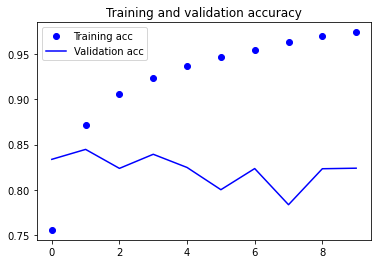

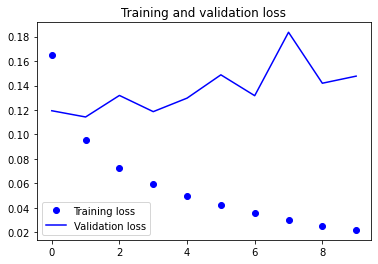

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 81.29%
loss: 0.15


Adding the Bidirectional layer to the LSTM network appears to provide no added advantage.

In [39]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(Bidirectional(GRU(32)))
model.add(Dense(1))

model.compile(optimizer=RMSprop(lr=0.0001), loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 41s 186ms/step - loss: 0.3343 - acc: 0.5079 - val_loss: 0.2441 - val_acc: 0.5724
Epoch 2/10
157/157 [==============================] - 27s 173ms/step - loss: 0.2370 - acc: 0.6095 - val_loss: 0.2318 - val_acc: 0.6300
Epoch 3/10
157/157 [==============================] - 27s 172ms/step - loss: 0.2185 - acc: 0.6792 - val_loss: 0.2123 - val_acc: 0.6766
Epoch 4/10
157/157 [==============================] - 28s 180ms/step - loss: 0.1902 - acc: 0.7372 - val_loss: 0.1834 - val_acc: 0.7270
Epoch 5/10
157/157 [==============================] - 28s 176ms/step - loss: 0.1560 - acc: 0.7897 - val_loss: 0.1587 - val_acc: 0.7770
Epoch 6/10
157/157 [==============================] - 28s 178ms/step - loss: 0.1332 - acc: 0.8328 - val_loss: 0.1463 - val_acc: 0.7974
Epoch 7/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1180 - acc: 0.8619 - val_loss: 0.1391 - val_acc: 0.8200
Epoch 8/10
157/157 [==============================] - 2

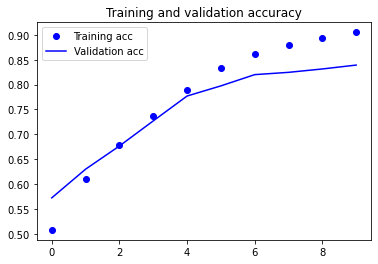

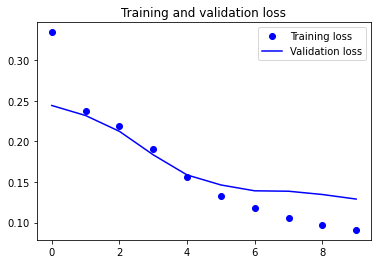

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
#Evaluating model performance on test data 
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("{}: {}".format(model.metrics_names[0], round(scores[0], 2)))

acc: 83.51%
loss: 0.13


Adding Bidirectional layer to GRU model did not appear to have provided any major advantages. It shows a small increase in accuracy on the test data. 